---

## Imports

In [1]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import xesmf as xe 
print(xe.__version__)
#import uxarray as ux 

0.8.7


## Read in unstructured data (MPAS grid)

In [2]:
mpas_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_save/')
mpas_path = Path('/Users/kukulies/mpas_dyamond/')
file_names = list(mpas_path.glob('diag.3.75km.2020-07-01*00.nc'))
file_names.sort()
len(file_names)

1

### Which variable to track on? 

Here we choose the **total ice water path** since the vertically integrated amount of frozen hydrometeors is an indicator for deep convection, since updrafts in deep convective clouds transport moist air high into the troposphere. 

This can be replaced with any other proxy for deep convection or variable of interest. 

In [3]:
# read in data for one day 
var = 'ice_water_path' 

for fname in file_names: 
    ds = xr.open_dataset(fname)[var].compute()
    if fname == file_names[0]:
        ice_water_path = ds
    else:
        ice_water_path  = xr.concat([ice_water_path, ds], dim = 'Time')

In [5]:
ice_water_path

<xarray.DataArray 'ice_water_path' (Time: 1, nCells: 41943042)> Size: 168MB
array([[22.140907, 16.388605, 16.041834, ...,  0.      ,  0.      ,
         0.      ]], shape=(1, 41943042), dtype=float32)
Dimensions without coordinates: Time, nCells
Attributes:
    units:      g m^{-2}
    long_name:  vertical integral of rho (qi+qs+qg)

## Regridding with **esmpy**

To define the source grid, we need information on the lat/lon values for each grid cell on the unstructured grid. 

In [6]:
# read in grid information for our MPAS simulation
grid = xr.open_dataset(mpas_path / 'x1.41943042.static.nc')

In [8]:
# Define the latitude and longitude ranges with 0.1-degree spacing
latitudes = np.arange(-90, 90.1, 0.1) 
longitudes = np.arange(0, 360.1, 0.1)  
lat, lon = np.meshgrid(latitudes, longitudes)

# Get lat/lon values from MPAS grid file 
lat_cell = grid['latCell'].values * 180 / np.pi  # radians to degrees
lon_cell = grid['lonCell'].values * 180 / np.pi

# Create an xarray Dataset for the target lat-lon grid 
target_grid = xr.Dataset({'lat': (['lat'], latitudes),'lon': (['lon'], longitudes)}) 

# Assign these coordinates to data 
ice_water_path.coords['lat'] = (('nCells',), lat_cell)
ice_water_path.coords['lon'] = (('nCells',), lon_cell)

# Source dataset: 1d array with attached lat/lon values 
source_ds = xr.Dataset({
    'lat': (['points'], lat_cell),
    'lon': (['points'], lon_cell),
    'ice_water_path': (['points'], ice_water_path.squeeze().values)
})

In [25]:
# Regridder class 
regridder = xe.Regridder(
    source_ds, target_grid,
    method='nearest_s2d',
    locstream_in=True,               
    reuse_weights = False
)

In [26]:
# Perform regridding
regridded = regridder(source_ds['ice_water_path'])

### Visualize output 

In [11]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

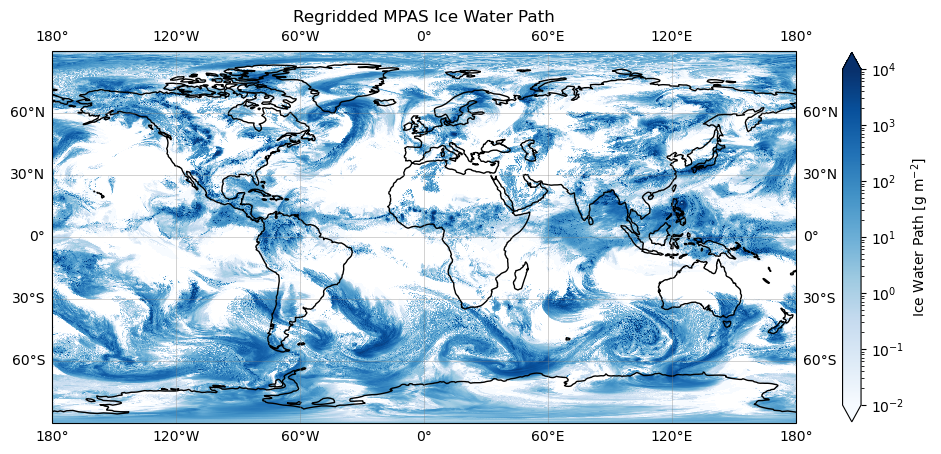

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # PlateCarree expects lat/lon coords

# Plot the DataArray using xarray's plot function, but give it the axis
regridded.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  
    cmap='Blues',
    norm=LogNorm(vmin=1e-2, vmax=1e4),
    cbar_kwargs={'label': 'Ice Water Path [g m$^{-2}$]', 'shrink': 0.8}
)

# Add coastlines
ax.coastlines(resolution='110m', linewidth=1)

# Optional: add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

plt.title('Regridded MPAS Ice Water Path')
plt.show()

### Save regridded data (optional, but practical in most cases)

In [31]:
# add metadata from original file
tt = np.datetime64('2020-07-01T00:00:00')
regridded = regridded.expand_dims(time=[tt])

# Rename the variable (if needed)
regridded.name = "ice_water_path"

# Assign metadata
regridded.attrs.update({
    'units': 'g m^-2',
    'long_name': 'Ice Water Path',
    'regrid_method': 'nearest_s2d',
    'source': 'MPAS-A DYAMOND 3',
    'comment': 'Regridded from MPAS unstructured mesh to 0.1° lat-lon grid'})

In [34]:
regridded

<xarray.DataArray 'ice_water_path' (time: 1, lat: 1801, lon: 3601)> Size: 26MB
array([[[ 5.2210693,  5.2210693,  5.2210693, ...,  5.2210693,
          5.2210693,  5.2210693],
        [ 4.4940534,  4.4940534,  4.4940534, ...,  4.217945 ,
          4.217945 ,  4.4940534],
        [ 3.297036 ,  3.297036 ,  3.297036 , ...,  3.297036 ,
          3.297036 ,  3.297036 ],
        ...,
        [ 3.386754 ,  3.386754 ,  3.386754 , ...,  3.386754 ,
          3.386754 ,  3.386754 ],
        [ 9.296441 ,  9.296441 ,  9.296441 , ..., 15.161509 ,
         15.161509 ,  9.296441 ],
        [16.384323 , 16.384323 , 16.384323 , ..., 16.384323 ,
         16.384323 , 16.384323 ]]], shape=(1, 1801, 3601), dtype=float32)
Coordinates:
  * time     (time) datetime64[s] 8B 2020-07-01
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.7 359.8 359.9 360.0
Attributes:
    regrid_method:  nearest_s2d
    units:          g m^-2
    long_name:      Ice Water Path
    source:         MPAS-A DYAMOND 3
    comment:        Regridded from MPAS unstructured mesh to 0.1° lat-lon grid

In [33]:
#save to netCDF file 
regridded.to_netcdf("mpas_ice_water_path_regridded.nc")

---

## Resources and references

- The full documentation of **xESMF** on **[Readthedocs](https://xesmf.readthedocs.io/en/stable/)**
- Alternative regridding methods:
  * [TempestRemap](https://github.com/ClimateGlobalChange/tempestremap)
  * [CDO](https://code.mpimet.mpg.de/projects/cdo/embedded/index.html)
  * [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_refdoc/) - Fortran, not the Python interface